In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [4]:
!nvidia-smi


Tue Sep 30 13:19:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:

import os

# Define key paths for convenience
dataset_dir = '/content/drive/MyDrive/ODIR-2019'
train_images_dir = os.path.join(dataset_dir, 'processed_images')
test_images_dir = os.path.join(dataset_dir, 'test_images_processed')
train_csv = os.path.join(dataset_dir, 'ODIR-5K_Training_Annotations(Updated)_V2.csv')
test_csv = os.path.join(dataset_dir, 'XYZ_ODIR.csv')


In [6]:
import pandas as pd

df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(test_csv)
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)


Train shape: (3231, 15)
Test shape: (500, 9)


In [7]:
# Disease mapping dictionary
disease_map = {
    'N': 'Normal', 'D': 'Diabetic Retinopathy', 'G': 'Glaucoma',
    'C': 'Cataract', 'A': 'AMD', 'H': 'Hypertension', 'M': 'Myopia', 'O': 'Other'
}

# Helper: Get full image path and labels
def fundus_records(row, img_folder):
    out = []
    for eye_type in ['Left-Fundus', 'Right-Fundus']:
        img_name = str(row[eye_type]).strip()
        img_path = os.path.join(img_folder, img_name)
        if os.path.exists(img_path):
            # Labels: grab N,D,G,C,A,H,M,O for this row
            labels = [row[k] for k in disease_map.keys()]
            out.append({'img_path': img_path, 'labels': labels})
    return out

# Build records: img path + labels
train_img_records = []
for idx, row in df_train.iterrows():
    train_img_records += fundus_records(row, train_images_dir)

print("First record:", train_img_records[0])
print("Total valid train images:", len(train_img_records))


First record: {'img_path': '/content/drive/MyDrive/ODIR-2019/processed_images/0_left.jpg', 'labels': [0, 0, 0, 1, 0, 0, 0, 0]}
Total valid train images: 3351


In [13]:
from PIL import Image

def is_valid_image(img_path):
    try:
        img = Image.open(img_path)
        img.verify()  # checks for corruption
        return True
    except:
        return False

train_img_records = [rec for rec in train_img_records if is_valid_image(rec['img_path'])]

print("After removing broken images:", len(train_img_records))


After removing broken images: 3351


In [8]:
!pip install scikit-multilearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 8.9 MB/s eta 0:00:00


In [9]:
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

records = train_img_records  # from the previous step
X = np.arange(len(records)).reshape(-1, 1)
Y = np.array([rec['labels'] for rec in records])

# First split: Train (80%) vs Temp (20%)
X_train, Y_train, X_temp, Y_temp = iterative_train_test_split(X, Y, test_size=0.2)

# Second split: Val (10%) vs Test (10%), equal split of the 20%
X_val, Y_val, X_test, Y_test = iterative_train_test_split(X_temp, Y_temp, test_size=0.5)

def subset(records, indices):
    # indices are shaped (N, 1).ravel() makes them 1D
    return [records[i] for i in indices.ravel()]

train_records = subset(records, X_train)
val_records = subset(records, X_val)
test_records = subset(records, X_test)

print(f"Train: {len(train_records)}, Val: {len(val_records)}, Test: {len(test_records)}")


Train: 2687, Val: 331, Test: 333


In [10]:
from sklearn.model_selection import train_test_split
# Split indices randomly (no stratification)
indices = np.arange(len(records))
train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_records = subset(records, train_idx)
val_records = subset(records, val_idx)
test_records = subset(records, test_idx)


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class FundusDataset(Dataset):
    def __init__(self, records, image_size=(224, 224)):
        self.records = records
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return len(self.records)
    def __getitem__(self, idx):
        img_path = self.records[idx]['img_path']
        labels = torch.tensor(self.records[idx]['labels'], dtype=torch.float32)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, labels, img_path

# Instantiate datasets
train_ds = FundusDataset(train_records)
val_ds = FundusDataset(val_records)
test_ds = FundusDataset(test_records)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)

# Print dataset stats
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")
img_ex, label_ex, path_ex = train_ds[0]
print("Example Image Path:", path_ex)
print("Label Example:", label_ex)
print("Disease Mappings:", [disease_map[k] for k, v in zip(disease_map.keys(), label_ex) if v > 0])


Train: 2680, Val: 335, Test: 336
Example Image Path: /content/drive/MyDrive/ODIR-2019/processed_images/1494_right.jpg
Label Example: tensor([0., 0., 1., 0., 0., 0., 0., 0.])
Disease Mappings: ['Glaucoma']


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Disease mapping
disease_map = {
    'N': 'Normal',
    'D': 'Diabetic Retinopathy',
    'G': 'Glaucoma',
    'C': 'Cataract',
    'A': 'AMD',
    'H': 'Hypertension',
    'M': 'Myopia',
    'O': 'Other'
}

# Load CSVs (use attached files in Colab, here use uploaded paths)
df_train = pd.read_csv('/content/drive/MyDrive/ODIR-2019/ODIR-5K_Training_Annotations(Updated)_V2.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ODIR-2019/XYZ_ODIR.csv')

# List of disease keys as in columns
cols = list(disease_map.keys())

# Aggregate counts from both CSVs (assuming both represent images)
def get_disease_counts(df):
    return df[cols].sum()

train_counts = get_disease_counts(df_train)
test_counts = get_disease_counts(df_test)
total_counts = train_counts + test_counts

# Human-readable mapping
total_counts_named = total_counts.rename(index=disease_map)

# Prepare data for plots
df_counts = total_counts_named.reset_index()
df_counts.columns = ['Disease', 'Count']

total_images = df_counts['Count'].sum()
df_counts['Percent'] = 100 * df_counts['Count'] / total_images

# Bar Chart
plt.figure(figsize=(10,6))
sns.barplot(x='Disease', y='Count', data=df_counts, palette='viridis')
plt.title('Number of Images per Eye Disease in ODIR-2019')
plt.xlabel('Eye Disease')
plt.ylabel('Number of Images')
for i, row in df_counts.iterrows():
    plt.text(i, row['Count']+max(df_counts['Count'])/60, f"{int(row['Count'])}", ha='center')
plt.tight_layout()
plt.savefig('bar_chart.png')
plt.close()

# Pie Chart
plt.figure(figsize=(7,7))
patches, texts, autotexts = plt.pie(df_counts['Count'], labels=df_counts['Disease'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(df_counts)))
for autotext in autotexts:
    autotext.set_color('white')
plt.title('% Distribution of Diseases in ODIR-2019')
plt.tight_layout()
plt.savefig('pie_chart.png')
plt.close()

# Seaborn Countplot (stacked with Pandas for multiclass)
# For visualization, melt disease columns to long-form
df_long = pd.concat([df_train, df_test])
df_long = df_long[['ID'] + cols].melt(id_vars='ID', var_name='Disease', value_name='Present')
df_long = df_long[df_long['Present']==1]
df_long['Disease'] = df_long['Disease'].map(disease_map)
plt.figure(figsize=(10,6))
sns.countplot(data=df_long, x='Disease', order=disease_map.values(), palette='viridis')
plt.title('Dataset Imbalance Visualization (Countplot)')
plt.xlabel('Eye Disease')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.savefig('countplot.png')
plt.close()

# Print summary table
df_summary = df_counts[['Disease','Count','Percent']].copy()
df_summary['Percent'] = df_summary['Percent'].round(2)
df_summary.to_csv('disease_summary.csv', index=False)
df_summary.head()  # Display summary as output table
# Chart images `bar_chart.png`, `pie_chart.png`, `countplot.png` are ready for display as Colab-friendly outputs.


/tmp/ipython-input-3906844295.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Disease', y='Count', data=df_counts, palette='viridis')
/tmp/ipython-input-3906844295.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_long, x='Disease', order=disease_map.values(), palette='viridis')


,Disease,Count,Percent
0,Normal,1004,26.41
1,Diabetic Retinopathy,1092,28.73
2,Glaucoma,199,5.24
3,Cataract,187,4.92
4,AMD,164,4.31


**Image** **Preprocessing**

In [16]:
import torch
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# For reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [17]:
image_size = 224  # or 256

# ImageNet normalization stats
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training transforms with augmentation
train_transforms = T.Compose([
    T.ConvertImageDtype(torch.float),  # convert PIL to float tensor
    T.Resize((image_size, image_size), interpolation=InterpolationMode.BILINEAR),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),  # small angle rotation ±10°
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.RandomResizedCrop(image_size, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    T.Normalize(mean=mean, std=std)
])

# Validation/Test transforms (no augmentation)
val_test_transforms = T.Compose([
    T.ConvertImageDtype(torch.float),
    T.Resize((image_size, image_size), interpolation=InterpolationMode.BILINEAR),
    T.Normalize(mean=mean, std=std)
])


In [18]:
from torch.utils.data import Dataset

class FundusDataset(Dataset):
    def __init__(self, records, transform=None):
        """
        records: list of dicts with keys {'img_path', 'labels'} or tuple (img_path, label)
        transform: torchvision.transforms pipeline
        """
        self.records = records
        self.transform = transform

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        # Support both dict or tuple input
        rec = self.records[idx]
        img_path = rec['img_path'] if isinstance(rec, dict) else rec[0]
        label = rec['labels'] if isinstance(rec, dict) else rec[1]

        img = Image.open(img_path).convert('RGB')

        # Convert PIL image to tensor before applying torchvision transforms which expect tensor or PIL
        img = T.PILToTensor()(img)  # (C, H, W), uint8

        if self.transform:
            img = self.transform(img)  # Already a tensor input here, transforms handle normalization

        label_tensor = torch.tensor(label, dtype=torch.float32)
        return img, label_tensor


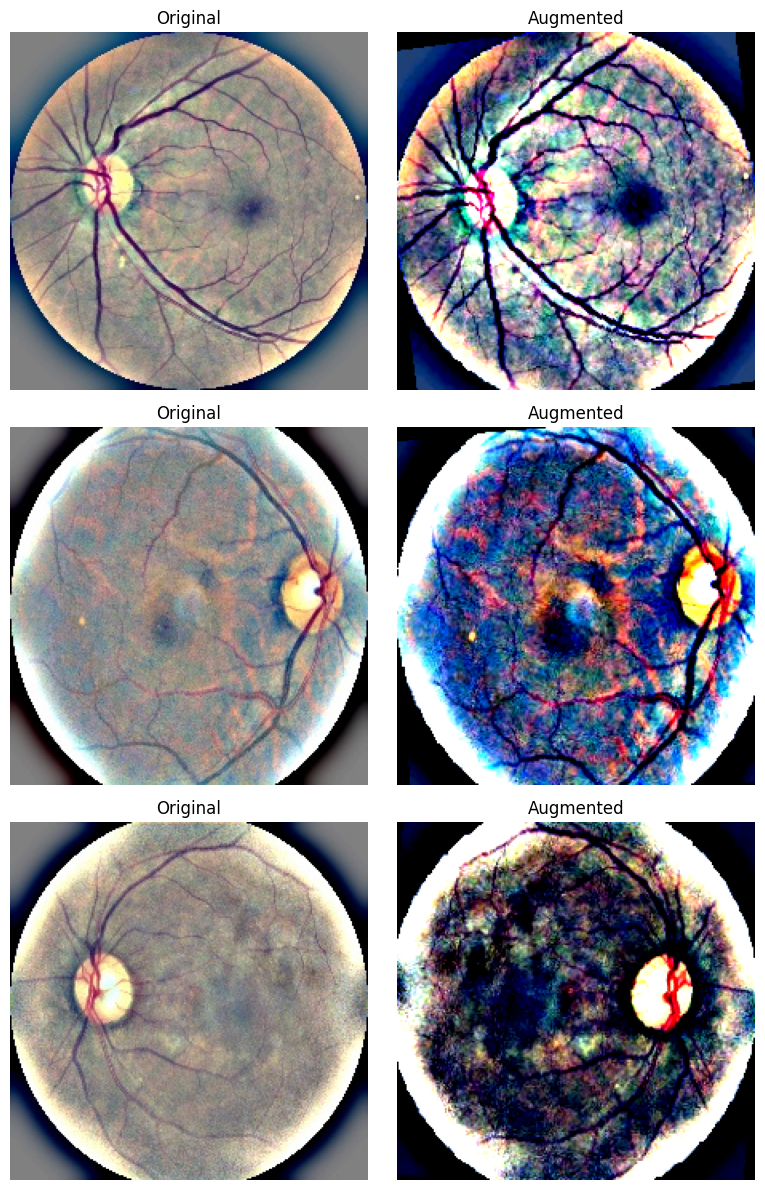

In [19]:
def imshow(img_tensor, title=None):
    # inverse normalize for display
    inv_normalize = T.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )
    img_disp = inv_normalize(img_tensor).permute(1, 2, 0).clamp(0, 1).cpu().numpy()
    plt.imshow(img_disp)
    if title:
        plt.title(title)
    plt.axis('off')

# Example usage
import random

# Select 3 random samples
sample_records = random.sample(train_records, 3)  # train_records prepared earlier

fig, axes = plt.subplots(3, 2, figsize=(8,12))

for i, rec in enumerate(sample_records):
    img_path = rec['img_path']
    label = rec['labels']

    # Original Image (normalized to [0,1])
    original_img = Image.open(img_path).convert('RGB')
    original_img_tensor = T.PILToTensor()(original_img).float() / 255.

    # Augmented Image
    transformed_img = train_transforms(T.PILToTensor()(original_img))

    imshow(original_img_tensor, title='Original Image',)
    axes[i, 0].imshow(original_img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')

    axes[i, 1].imshow(transformed_img.permute(1,2,0).clamp(0,1))
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Augmented')
plt.tight_layout()
plt.show()


**Model Architecture &** **Training**

In [20]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

# Minimal transform for loading preprocessed images
val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class FundusPreprocessedDataset(Dataset):
    def __init__(self, records, transform=val_test_transforms):
        self.records = records
        self.transform = transform

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        img_path = self.records[idx]['img_path'] if isinstance(self.records[idx], dict) else self.records[idx][0]
        label = self.records[idx]['labels'] if isinstance(self.records[idx], dict) else self.records[idx][1]

        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label_tensor = torch.tensor(label, dtype=torch.float32)
        return img, label_tensor


In [21]:
train_dataset = FundusPreprocessedDataset(train_records)
val_dataset = FundusPreprocessedDataset(val_records)
test_dataset = FundusPreprocessedDataset(test_records)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [22]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Replace final fc layer to match 8 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)  # 8 disease classes
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 50.7MB/s]


Epoch 1 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.46it/s, loss=1.28]


Epoch 1: Train loss 1.2646, Train acc 0.5929, Val loss 1.2189, Val acc 0.5851
Saved model with val acc 0.5851


Epoch 2 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.72it/s, loss=1.25]


Epoch 2: Train loss 0.7661, Train acc 0.7392, Val loss 1.1980, Val acc 0.5642


Epoch 3 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.53it/s, loss=1.71]


Epoch 3: Train loss 0.3423, Train acc 0.8955, Val loss 1.6312, Val acc 0.5821


Epoch 4 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.54it/s, loss=1.69]


Epoch 4: Train loss 0.1502, Train acc 0.9586, Val loss 1.6124, Val acc 0.5970
Saved model with val acc 0.5970


Epoch 5 Validation: 100%|██████████| 11/11 [00:01<00:00,  5.80it/s, loss=1.64]


Epoch 5: Train loss 0.0937, Train acc 0.9720, Val loss 1.7256, Val acc 0.5791


Epoch 6 Validation: 100%|██████████| 11/11 [00:02<00:00,  5.29it/s, loss=1.76]


Epoch 6: Train loss 0.0578, Train acc 0.9836, Val loss 1.8499, Val acc 0.5731


Epoch 7 Validation: 100%|██████████| 11/11 [00:02<00:00,  4.57it/s, loss=1.86]


Epoch 7: Train loss 0.0560, Train acc 0.9854, Val loss 1.9592, Val acc 0.5731


Epoch 8 Validation: 100%|██████████| 11/11 [00:02<00:00,  5.23it/s, loss=1.9]


Epoch 8: Train loss 0.0461, Train acc 0.9903, Val loss 1.8171, Val acc 0.5731


Epoch 9 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.74it/s, loss=2.03]


Epoch 9: Train loss 0.0300, Train acc 0.9937, Val loss 1.9352, Val acc 0.6060
Saved model with val acc 0.6060


Epoch 10 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.73it/s, loss=2.1]


Epoch 10: Train loss 0.0361, Train acc 0.9899, Val loss 2.0066, Val acc 0.6209
Saved model with val acc 0.6209


Epoch 11 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.71it/s, loss=2.17]


Epoch 11: Train loss 0.0165, Train acc 0.9959, Val loss 2.0704, Val acc 0.6000


Epoch 12 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.59it/s, loss=2.17]


Epoch 12: Train loss 0.0101, Train acc 0.9985, Val loss 2.0703, Val acc 0.6149


Epoch 13 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.54it/s, loss=2.3]


Epoch 13: Train loss 0.0036, Train acc 1.0000, Val loss 2.1936, Val acc 0.6149


Epoch 14 Validation: 100%|██████████| 11/11 [00:02<00:00,  4.84it/s, loss=1.89]


Epoch 14: Train loss 0.0066, Train acc 0.9993, Val loss 1.9854, Val acc 0.6090


Epoch 15 Validation: 100%|██████████| 11/11 [00:02<00:00,  5.34it/s, loss=2.31]


Epoch 15: Train loss 0.0038, Train acc 1.0000, Val loss 2.2084, Val acc 0.6358
Saved model with val acc 0.6358


Epoch 16 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.53it/s, loss=2.28]


Epoch 16: Train loss 0.0050, Train acc 0.9993, Val loss 2.1788, Val acc 0.6328


Epoch 17 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.71it/s, loss=2.12]


Epoch 17: Train loss 0.0017, Train acc 1.0000, Val loss 2.0261, Val acc 0.6239


Epoch 18 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.65it/s, loss=2.04]


Epoch 18: Train loss 0.0018, Train acc 0.9996, Val loss 1.9510, Val acc 0.6299


Epoch 19 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.30it/s, loss=2.19]


Epoch 19: Train loss 0.0019, Train acc 0.9996, Val loss 2.0892, Val acc 0.6358


Epoch 20 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.53it/s, loss=2.13]


Epoch 20: Train loss 0.0010, Train acc 1.0000, Val loss 2.2406, Val acc 0.6358


Epoch 21 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.46it/s, loss=2.38]


Epoch 21: Train loss 0.0017, Train acc 0.9996, Val loss 2.2765, Val acc 0.6328


Epoch 22 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.24it/s, loss=2.01]


Epoch 22: Train loss 0.0015, Train acc 1.0000, Val loss 2.1155, Val acc 0.6328


Epoch 23 Validation: 100%|██████████| 11/11 [00:03<00:00,  2.86it/s, loss=1.92]


Epoch 23: Train loss 0.0010, Train acc 1.0000, Val loss 2.0148, Val acc 0.6299


Epoch 24 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.65it/s, loss=2.07]


Epoch 24: Train loss 0.0009, Train acc 1.0000, Val loss 1.9776, Val acc 0.6299


Epoch 25 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.20it/s, loss=2.11]


Epoch 25: Train loss 0.0009, Train acc 1.0000, Val loss 2.2165, Val acc 0.6239


Epoch 26 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.75it/s, loss=2.02]


Epoch 26: Train loss 0.0008, Train acc 1.0000, Val loss 2.1203, Val acc 0.6328


Epoch 27 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.65it/s, loss=2.25]


Epoch 27: Train loss 0.0010, Train acc 1.0000, Val loss 2.1496, Val acc 0.6358


Epoch 28 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.55it/s, loss=2.27]


Epoch 28: Train loss 0.0010, Train acc 1.0000, Val loss 2.1665, Val acc 0.6269


Epoch 29 Validation: 100%|██████████| 11/11 [00:01<00:00,  6.51it/s, loss=1.88]


Epoch 29: Train loss 0.0009, Train acc 1.0000, Val loss 1.9706, Val acc 0.6328


Epoch 30 Validation: 100%|██████████| 11/11 [00:02<00:00,  5.22it/s, loss=1.97]


Epoch 30: Train loss 0.0011, Train acc 1.0000, Val loss 2.0692, Val acc 0.6358


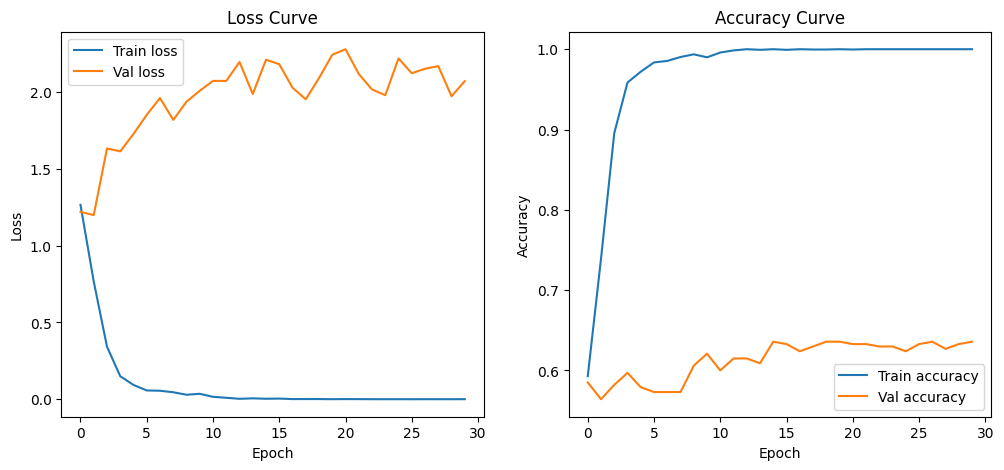

In [23]:
import torch
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

best_val_acc = 0
num_epochs = 30

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss_total = 0
    train_preds, train_labels = [], []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.argmax(dim=1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_total += loss.item() * images.size(0)

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        pbar.set_postfix(loss=train_loss_total / ((pbar.n + 1) * train_loader.batch_size))

    train_loss = train_loss_total / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss_total = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation")
        for images, labels in pbar:
            images, labels = images.to(device), labels.argmax(dim=1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            pbar.set_postfix(loss=val_loss_total / ((pbar.n + 1) * val_loader.batch_size))

    val_loss = val_loss_total / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train loss {train_loss:.4f}, Train acc {train_acc:.4f}, Val loss {val_loss:.4f}, Val acc {val_acc:.4f}")

    # Save best model checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/ODIR-2019/best_resnet50_odir_multilabel.pth')
        print(f"Saved model with val acc {best_val_acc:.4f}")

    scheduler.step()

# Plot training and validation loss/accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train accuracy')
plt.plot(val_accs, label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


In [25]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.2 MB/s eta 0:00:00


In [26]:
!pip install streamlit pyngrok

In [34]:
import streamlit as st
from PIL import Image
import torch
import torchvision.transforms as transforms
from pyngrok import ngrok
import torchvision.models as models
import torch.nn as nn

# Set ngrok authentication token here
NGROK_AUTH_TOKEN = "33QHISj3rAkj67wanYs9B5KvGgu_rxfSqdtvY51Stu6A5oMj"  # <-- Put your ngrok token string here

# Authenticate ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Disease Names
disease_names = ["Normal", "Diabetic Retinopathy", "Glaucoma", "Cataract", "AMD", "Hypertension", "Myopia", "Other"]

# Model definition: must match training!
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)
model.load_state_dict(torch.load("/content/drive/MyDrive/ODIR-2019/best_resnet50_odir_multilabel.pth", map_location='cpu'))
model.eval()

# Preprocessing pipeline (must match training/test)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

st.title("Fundus Disease Detection")
st.subheader("Upload Fundus Image")

uploaded_file = st.file_uploader("Choose a fundus image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert('RGB')
    st.image(image, caption='Uploaded Fundus Image', use_column_width=True)

    if st.button("Analyze Image"):
        img_tensor = val_test_transforms(image).unsqueeze(0)
        with torch.no_grad():
            logits = model(img_tensor)
            probs = torch.softmax(logits, dim=1)
            conf, pred_idx = torch.max(probs, dim=1)

        predicted_disease = disease_names[pred_idx.item()]
        confidence = conf.item() * 100

        st.markdown(f"## Diagnosis: <span style='color:lime'>{predicted_disease}</span>", unsafe_allow_html=True)
        st.markdown(f"**Confidence:** {confidence:.2f}%")
        st.progress(int(confidence))

        if predicted_disease == "Normal":
            st.success("Risk Level: Low")
            st.markdown("#### Recommendations")
            st.markdown("""
            - Schedule annual eye exams
            - Maintain a healthy diet rich in vitamins A and C
            - Protect eyes from UV radiation
            - Monitor for any vision changes
            """)
        else:
            st.warning(f"Risk Level: {predicted_disease}")
            st.markdown("#### Recommendations")
            st.markdown("""
            - Consult an ophthalmologist promptly
            - Follow up with specialist for treatment
            - Adhere to doctor's advice carefully
            """)

        st.markdown("#### Disease Confidence Levels")
        for i, d_name in enumerate(disease_names):
            st.write(f"{d_name}: {probs[0, i].item()*100:.2f}%")


2025-09-30 14:30:17.939 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-30 14:30:17.939 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-30 14:30:17.940 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-30 14:30:17.941 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-30 14:30:17.942 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-30 14:30:17.943 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-30 14:30:17.944 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-30 14:30:17.944 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [35]:
from pyngrok import ngrok
ngrok.kill()
public_url = ngrok.connect(port=8501)
print(f"Your Streamlit app link: {public_url}")
!streamlit run app.py &


PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel"}}
